In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import sys
plt.style.use("dark_background") 
sys.path.append("../src/inference")
from score_models import ScoreModel
from forward_model import complex_to_real, score_likelihood, model
# from posterior_sampling import euler_sampler, complex_to_real, real_to_complex, sigma, mu
# from forward_model import ft, ift, model, score_likelihood, link_function, noise_padding
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
score_model = ScoreModel(checkpoints_directory="/home/noedia/projects/rrg-lplevass/data/score_models/ncsnpp_vp_skirt_z_256_230813225243/")

Using the Variance Preserving SDE


In [124]:
pixel_scale = 0.0015
img_size = 256
npix = 4096
pad = (npix-img_size)//2

# Importing data
# data_dir = "/home/noedia/projects/rrg-lplevass/data/htlup_4096_gridded_sinc.npz"
# data_dir = "/home/noedia/scratch/bayesian_imaging_radio/dsharp_npz/HD163296_gridded_sinc_4096.npz"
data_dir = "/home/noedia/scratch/bayesian_imaging_radio/dsharp_gridded/WSB52_continuum_4096_gridded_sinc.npz"
with np.load(data_dir) as data_gridded: 
        vis_bin_re = torch.tensor(data_gridded["vis_bin_re"]).to(device)
        vis_bin_imag = torch.tensor(data_gridded["vis_bin_imag"]).to(device)
        std_bin_re = torch.tensor(data_gridded["std_bin_re"]).to(device)
        std_bin_imag = torch.tensor(data_gridded["std_bin_imag"]).to(device)
        counts = torch.tensor(data_gridded["counts"]).to(device)


In [125]:
mask = counts>0
S = mask

vis_sampled = (vis_bin_re + 1j * vis_bin_imag)[S]
std_sampled = (std_bin_re + 1j * std_bin_imag)[S]

# Complex tensors into their vectorized real representations + FT normalization.
y = complex_to_real(vis_sampled) * npix
sigma_y = complex_to_real(std_sampled) * npix

# Irregular padding strategy depending on the position of the image on teh 4096x4096 pixel grid.
xshift = 50
yshift = 220
# Irregular padding 
xc = npix//2 - xshift # center of the 256*256 pixel grid we want to reconstruct
yc = npix//2 - yshift 

# Irregular padding
pad_b = (yc - img_size // 2)
pad_t = npix - (yc + img_size // 2)
pad_l = (xc - img_size // 2)
pad_r = npix - (xc + img_size // 2)
pad = (pad_l, pad_r, pad_b, pad_t) # torch convention (pad left, pad right, pad bottom, pad top)

B, C = 1, 0 # link function parameters
padding_mode = "noise" # either 'noise' or 'zero' 
model_params = (S, B, C, pad, padding_mode)

In [ ]:
dirty_image.argmax()

In [126]:
from forward_model import ft, ift,ftshift, iftshift
def flip(x):
    return torch.flip(x, dims = [-1])
dirty_image = ftshift(ift(iftshift(vis_bin_re + 1j * vis_bin_imag))).real
# Centering on the middle pixel


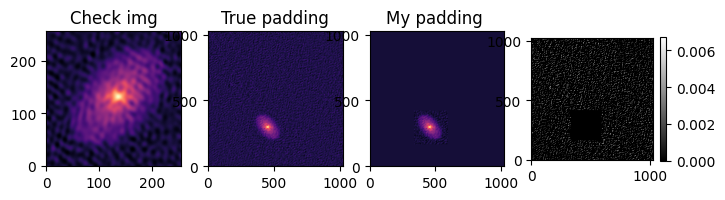

In [131]:
Dy = yc-img_size//2
Uy = yc+img_size//2
Dx = xc-img_size//2
Ux = xc+img_size//2
nopad_dirty = dirty_image[Dy:Uy, Dx:Ux]
dirty_padded = torch.nn.functional.pad(nopad_dirty, pad = pad)

fig, axs = plt.subplots(1, 4, figsize = (8, 4))
D = npix//2 - 512
U = npix//2 + 512

axs[0].imshow(flip(nopad_dirty).cpu().squeeze(), cmap = "magma", origin = "lower")
axs[0].set_title("Check img")
axs[1].imshow(dirty_image[D:U, D:U].cpu().squeeze(), cmap = "magma", origin = "lower")
axs[1].set_title("True padding") 
axs[2].imshow(dirty_padded[D:U, D:U].cpu().squeeze(), cmap = "magma", origin = "lower")
axs[2].set_title("My padding ")

im = axs[3].imshow((dirty_padded - dirty_image)[D:U, D:U].cpu().squeeze(), cmap = "gray", origin = "lower", vmin = 0)
plt.colorbar(im, fraction = 0.046)
plt.subplots_adjust(wspace = 0.2)

Nice it's working, now let's just add this to our forward model. We'll just change the pad, parameters that's taken in by the forward model and make it a Tuple matching torch's convention. 

In [8]:
from torch.func import vmap, grad
from posterior_sampling import sigma, mu
from forward_model import link_function, ft, ift
def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out
def regular_padding(x, pad):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad))
    return out

def model(t, x, score_model, model_parameters): 
    """Apply a physical model A to a ground-truth x.

    Args:
        t (torch.Tensor): temperature in the sampling procedure of diffusion models.
        x (torch.Tensor): ground-truth 
        score_model (torch.Tensor): trained score-based model (= the score of a prior)
        model_parameters (Tuple): list of parameters for the model (sampling_function, B, C)
          - index 0: sampling function (mask selecting the measured visibilities in Fourier space, must have a shape (H, W) where H and W are the height
            and width of the padded image respectively)
          - index 1 and index 2: B and C, the link_function parameters (see function link_function)

    Returns:
        y_hat (torch.Tensor): 
    """

    sampling_function, B, C, pad= model_parameters

    # TODO: ADD OPTION FOR BATCHED INPUT (in order to forward model multiple    
    # x_padded = noise_padding(x.squeeze(), pad = pad, sigma = sigma(t, score_model))
    x = torch.flip(x, dims=[-1]) # Enforcing good orientation for the final image
    x_padded = noise_padding(x.squeeze(), pad = pad, sigma = sigma(t, score_model))
    x_padded = link_function(x_padded, B=B, C=C)
    vis_sampled = ftshift(ft(iftshift(x_padded))).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    y_hat = complex_to_real(vis_sampled)
    return y_hat

def log_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = forward_model(t, x, score_model, model_parameters)
    Gamma_diag = torch.ones_like(y, device = y.device)/2
    Gamma_diag[0] = 1 

    var = sigma(t, score_model) **2 * Gamma_diag + mu(t, score_model)**2 * sigma_y**2 ## sigma(t) ** 2 * AA^T + sigma_y ** 2
    res = (mu(t, score_model) * y - y_hat) ** 2 / var
    log_prob = -0.5 * torch.sum(res)
    return log_prob

def score_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters):
    return vmap(grad(lambda x, t:  log_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters)), randomness = "different")(x, t)

x = torch.randn([1, 1, img_size, img_size]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(t, x, y, sigma_y, model, score_model, model_params)**2))**0.5)

tensor(139.5102, device='cuda:0')


In [132]:
from posterior_sampling import euler_sampler, pc_sampler
# pred_steps, corr_steps, snr = pc_params
# pc_params = (4000, 1, 0.1)
# samples = pc_sampler(
#     y = y,
#     sigma_y = sigma_y, 
#     forward_model = model, 
#     score_model = score_model,
#     score_likelihood = score_likelihood, 
#     model_parameters = model_params,
#     num_samples = 1,
#     pc_params = pc_params,  
#     tweedie = False, 
#     keep_chain = False, 
#     debug_mode = False, 
#     img_size = (256, 256)
# )

samples = euler_sampler(
    y = y,
    sigma_y = sigma_y, 
    forward_model = model, 
    score_model = score_model,
    score_likelihood =  score_likelihood, 
    model_parameters = model_params,
    num_samples = 1,
    num_steps = 4000,  
    tweedie = False, 
    keep_chain = False, 
    debug_mode = False, 
    img_size = (256, 256)
)

t = 0.00 | scale ~ 2.60e+01 | sigma(t) = 2.84e-03 | mu(t) = 1.00e+00: 100%|██████████| 3999/3999 [05:24<00:00, 12.32it/s]


In [134]:
np.save("WSB52_samples.npy",samples.cpu().squeeze().numpy())

True


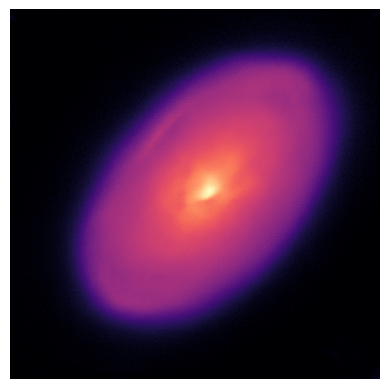

In [133]:
from astropy.visualization import ImageNormalize, AsinhStretch
norm = True
save = False
plt.style.use("default")
n_images = samples.shape[0]
grid_size = int(n_images**0.5)
if False:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch(a=0.00001))
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((link_function(samples[k])).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"/home/noedia/projects/def-lplevass/noedia/bayesian_imaging_radio/images/HTLup_pad{npix}norm.pdf"
        norm = ImageNormalize((samples/samples.max()).cpu().numpy(), vmin = 0, stretch = AsinhStretch(a=0.05))
    else: 
        save_path = f"/home/noedia/projects/def-lplevass/noedia/bayesian_imaging_radio/images/HTLup_pad{img_size}nonorm.pdf"
        norm = None
    plt.imshow((samples[0]/samples[0].max()).squeeze().cpu(), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

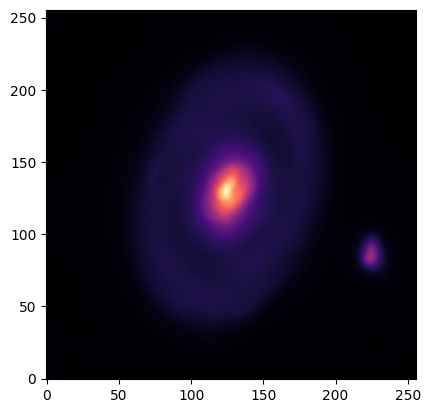

In [145]:
plt.imshow(torch.flip(samples.squeeze().cpu(), dims = [-1]), cmap = "magma", origin = "lower")

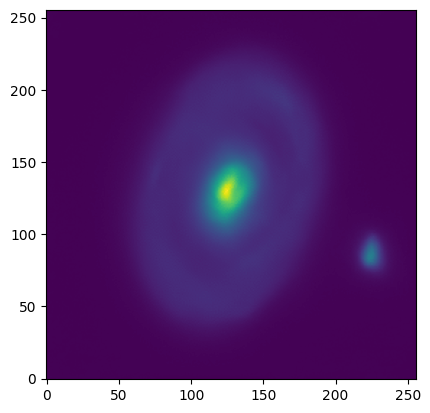

In [144]:
plt.imshow(np.array(samples.cpu()).squeeze()[:,::-1], origin = "lower")

In [ ]:
def model_no_pad(x):
    sampling_function, B, C, pad= model_parameters

    # TODO: ADD OPTION FOR BATCHED INPUT (in order to forward model multiple    
    x_padded = noise_padding(x.squeeze(), pad = pad, sigma = sigma(t, score_model))
    x_padded = link_function(x_padded, B=B, C=C)
    vis_sampled = ft(ftshift(x_padded)).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    y_hat = complex_to_real(vis_sampled)
    return y_hat

In [18]:
y_hat = model(t = torch.zeros(size = (1,)).to(device),x = samples, score_model = score_model, model_parameters = model_params)
y_hat

tensor([316.7818, 316.2704, 314.7421,  ...,  -3.9911,  -2.8414,  -1.5980],
       device='cuda:0')

In [33]:
sample = score_model.sample(steps = 500, shape = (1, 1, 256, 256))

Sampling from the prior | t = 0.0 | sigma = 7.8e-03| scale ~ 2.0e+01: 100%|██████████| 500/500 [00:36<00:00, 13.58it/s]


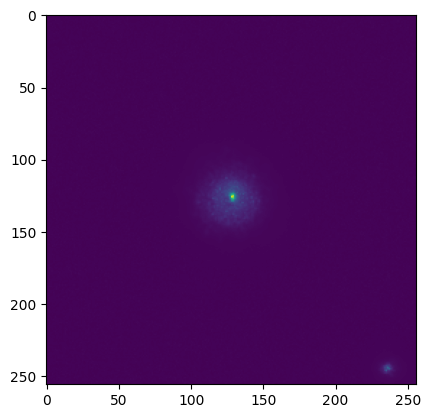

In [35]:
plt.imshow(sample.cpu().squeeze())

In [111]:
def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

def model1(t, x, score_model, model_parameters): 
    """Apply a physical model A to a ground-truth x.

    Args:
        t (torch.Tensor): temperature in the sampling procedure of diffusion models.
        x (torch.Tensor): ground-truth 
        score_model (torch.Tensor): trained score-based model (= the score of a prior)
        model_parameters (Tuple): list of parameters for the model (sampling_function, B, C)
          - index 0: sampling function (mask selecting the measured visibilities in Fourier space, must have a shape (H, W) where H and W are the height
            and width of the padded image respectively)
          - index 1 and index 2: B and C, the link_function parameters (see function link_function)

    Returns:
        y_hat (torch.Tensor): 
    """

    sampling_function, B, C, pad= model_parameters

    # TODO: ADD OPTION FOR BATCHED INPUT (in order to forward model multiple)   
    x_padded = noise_padding(x.squeeze(), pad = pad, sigma = sigma(t, score_model))
    x_padded = link_function(x_padded, B=B, C=C)
    # return ftshift(x_padded)
    vis_sampled = ft(ftshift(x_padded)).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    y_hat = complex_to_real(vis_sampled)
    return y_hat

def model2(t, x, score_model, model_parameters): 
    """Apply a physical model A to a ground-truth x.

    Args:
        t (torch.Tensor): temperature in the sampling procedure of diffusion models.
        x (torch.Tensor): ground-truth 
        score_model (torch.Tensor): trained score-based model (= the score of a prior)
        model_parameters (Tuple): list of parameters for the model (sampling_function, B, C)
          - index 0: sampling function (mask selecting the measured visibilities in Fourier space, must have a shape (H, W) where H and W are the height
            and width of the padded image respectively)
          - index 1 and index 2: B and C, the link_function parameters (see function link_function)

    Returns:
        y_hat (torch.Tensor): 
    """

    sampling_function, B, C, pad= model_parameters

    # TODO: ADD OPTION FOR BATCHED INPUT (in order to forward model multiple)   
    x_padded = noise_padding(x.squeeze(), pad = pad, sigma = sigma(t, score_model))
    x_padded = link_function(x_padded, B=B, C=C)
    # return ftshift(x_padded)
    # Ensuring that the DC component is the middle frequency after the FFT
    vis_sampled = ftshift(ft(ftshift(x_padded))).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    y_hat = complex_to_real(vis_sampled)
    return y_hat

In [117]:
shift = -43885  # to go from y to y_shifted

In [112]:
t = torch.zeros(size = (1,)).to(device)
x = sample
model_parameters_shift = (S_shift, B, C, pad)
model_parameters = (S, B, C, pad)
y_hat1 = model1(t, x, score_model, model_parameters_shift)
y_hat2 = model2(t, x, score_model, model_parameters)

In [114]:
y_hat1

tensor([0.9771, 0.9762, 0.9736,  ..., 0.0304, 0.0235, 0.0159], device='cuda:0')

In [118]:
torch.roll(y_hat2, shifts = shift)

tensor([0.9771, 0.9762, 0.9736,  ..., 0.9692, 0.9736, 0.9762], device='cuda:0')

In [113]:
y_hat1.max()
y_hat2.max()

tensor(0.9771, device='cuda:0')

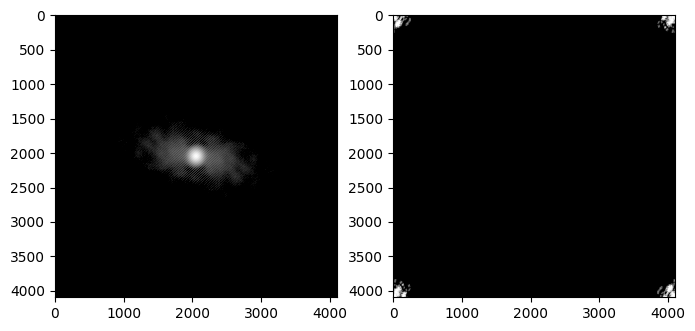

In [109]:
x_padded = noise_padding(x.squeeze(), pad = pad, sigma = torch.zeros_like(sigma(t, score_model)))
x_padded = link_function(x_padded, B=B, C=C)
# return ftshift(x_padded)
from matplotlib.colors import LogNorm
norm = LogNorm(vmin = 1e-2, vmax = 1, clip = True)

fig, axs = plt.subplots(1, 2, figsize = (8,4))
vis_sampled = ft(ftshift(x_padded)).squeeze()
im = axs[0].imshow(vis_sampled.real.cpu(), norm = norm, cmap  = "gray")
# plt.colorbar(im)

im = axs[1].imshow(S_shift.cpu(), cmap = "gray")

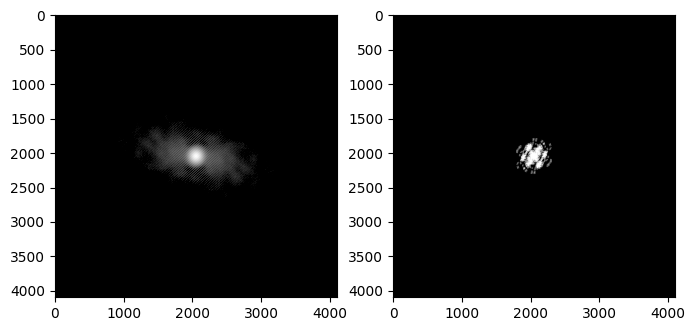

In [110]:
x_padded = noise_padding(x.squeeze(), pad = pad, sigma = torch.zeros_like(sigma(t, score_model)))
x_padded = link_function(x_padded, B=B, C=C)
# return ftshift(x_padded)
from matplotlib.colors import LogNorm
norm = LogNorm(vmin = 1e-2, vmax = 1, clip = True)

fig, axs = plt.subplots(1, 2, figsize = (8,4))
vis_sampled = ftshift(ft(ftshift(x_padded))).squeeze()
im = axs[0].imshow(vis_sampled.real.cpu(), norm = norm, cmap  = "gray")
# plt.colorbar(im)

im = axs[1].imshow(S.cpu(), cmap = "gray")

Text(0.5, 1.0, 'Fft shift')

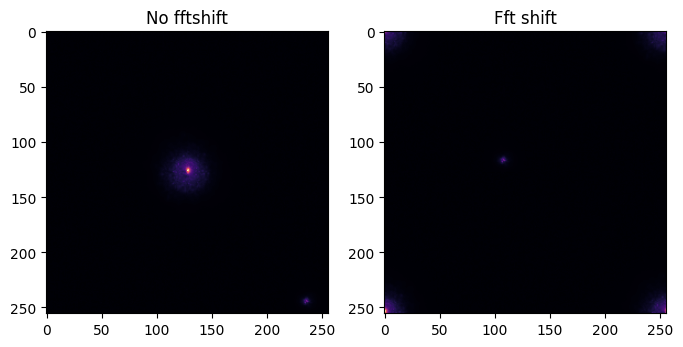

In [128]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
axs[0].imshow(sample.cpu().squeeze(), cmap = "magma")
axs[0].set_title("No fftshift")
axs[1].imshow(ftshift(sample).cpu().squeeze(), cmap = "magma")
axs[1].set_title("Fft shift")


In [82]:
def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

def sigma(t):
    return score_model.sde.sigma(t)

def mu(t):
    return score_model.sde.marginal_prob_scalars(t)[0]

def model(t, x, score_model, model_parameters): 
    """Apply a physical model A to a ground-truth x.

    Args:
        t (torch.Tensor): temperature in the sampling procedure of diffusion models.
        x (torch.Tensor): ground-truth 
        score_model (torch.Tensor): trained score-based model (= the score of a prior)
        model_parameters (Tuple): list of parameters for the model (sampling_function, B, C)
          - index 0: sampling function (mask selecting the measured visibilities in Fourier space, must have a shape (H, W) where H and W are the height
            and width of the padded image respectively)
          - index 1 and index 2: B and C, the link_function parameters (see function link_function)

    Returns:
        y_hat (torch.Tensor): 
    """

    sampling_function, B, C, pad= model_parameters

    # TODO: ADD OPTION FOR BATCHED INPUT (in order to forward model multiple    
    x_padded = noise_padding(x.squeeze(), pad = pad, sigma = sigma(t, score_model))
    vis_sampled = ft(shift(x_padded)).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    
    # vis_sampled = vis_sampled.reshape(num_vis,)
    y_hat = complex_to_real(vis_sampled)
    return y_hat

B= 1
C = 0
model_parameters = (S_shift, B, C, pad)
k = torch.randn([1, 1, img_size, img_size], dtype = torch.float32).to(device) 
t = torch.ones([1]).to(device)

In [83]:
from torch.func import vmap, grad
import sys
sys.path.append("../src/inference")
from posterior_sampling import sigma, mu

# Diagonal of Gamma = AA^T (in real representation of a complex matrix)
Gamma_diag = torch.ones(size = (len(y), )).to(device)/2
Gamma_diag[0] = 1 

def log_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = forward_model(t, x, score_model, model_parameters)
    Gamma_diag = torch.ones_like(y, device = y.device)/2
    Gamma_diag[0] = 1 

    var = sigma(t, score_model) **2 * Gamma_diag + mu(t, score_model)**2 * sigma_y**2 ## sigma(t) ** 2 * AA^T + sigma_y ** 2
    res = (mu(t, score_model) * y - y_hat) ** 2 / var
    log_prob = -0.5 * torch.sum(res)
    return log_prob

def score_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters):
    return vmap(grad(lambda x, t: log_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters)), randomness = "different")(x, t)

#torch.manual_seed(0)
def score_posterior(t, x): 
    return score_model.score(t, x) + score_likelihood(t, x, y, sigma_y, ) 

model_params = (S_shift, B, C, pad)
k = torch.randn([1, 1, img_size, img_size]).to(device) 
t = torch.ones([1,]).to(device)

print((torch.sum(score_likelihood(t, k, y, sigma_y, model, score_model, model_params)**2))**0.5)
# print(score_posterior(t, k))

tensor(142.8551, device='cuda:0')


In [80]:
from posterior_sampling import euler_sampler

samples = euler_sampler(
    y = y,
    sigma_y = sigma_y, 
    forward_model = model, 
    score_model = score_model,
    score_likelihood = score_likelihood, 
    model_parameters = model_params, 
    num_samples = 1, 
    num_steps = 4000, 
    tweedie = False, 
    keep_chain = False, 
    debug_mode = False, 
    img_size = (256, 256)
)


t = 0.00 | scale ~ 3.63e+01 | sigma(t) = 2.84e-03 | mu(t) = 1.00e+00: 100%|██████████| 3999/3999 [05:20<00:00, 12.47it/s]


False


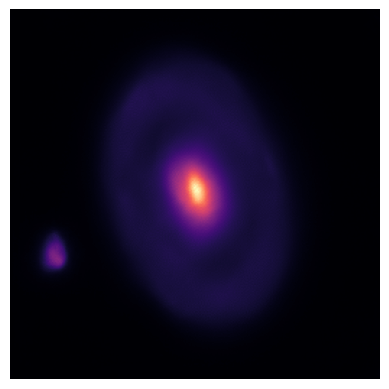

In [81]:
norm = False
save = False
plt.style.use("default")
n_images = samples.shape[0]
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch(a=0.8))
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((link_function(samples[k])).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"/home/noedia/projects/def-lplevass/noedia/bayesian_imaging_radio/images/HTLup_pad{npix}norm.pdf"
        norm = ImageNormalize((samples/samples.max()).cpu().numpy(), vmin = 0, stretch = AsinhStretch(a=0.9))
    else: 
        save_path = f"/home/noedia/projects/def-lplevass/noedia/bayesian_imaging_radio/images/HTLup_pad{img_size}nonorm.pdf"
        norm = None
    plt.imshow((samples[0]/samples[0].max()).squeeze().cpu(), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

Doing tests with new code with VP Skirt with old HTLuP gridded.  